<a href="https://colab.research.google.com/github/eduardokern/ML/blob/main/notebooks/transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning (BairesDev treinamento ML)

O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.  

Para exemplo, utilizaremos o seguinte projeto que realiza Transfer Learning com o Dataset do MNIST:
https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

O dataset utilizado engloba duas classes: gatos e cachorros. Uma descrição da base de dados pode ser visualizada neste link: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs.

Já o dataset para download pode ser acessado por meio deste outro link:

https://www.microsoft.com/en-us/download/details.aspx?id=54765.

Observações: Neste projeto, você pode usar sua própria base de dados (exemplo: fotos suas, dos seus pais, dos seus amigos, dos seus animais domésticos, etc), o exemplo de gatos e cachorros, pode ser substituído por duas outras classes do seu interesse. O Dataset criado em nosso projeto anterior, pode ser utilizado agora.  

O projeto deve ser enviado para o GitHub da DIO: https://github.com/digitalinnovationone.


### Baixando o dataset

Será utilizado o dataset [Kaggle Cats and Dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765) a ser baixado pelo comando:

    curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
    unzip kagglecatsanddogs_5340.zip

In [28]:
!echo "Downloading kagglecatsanddogs_5340.zip for image notebooks"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!echo "Extracting images..."
!rm -rf PetImages
!unzip -qo kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip
!echo "Done."


############################################################################################# 100.0%
Extracting images
Done.


### Python imports

Importando pacotes e módulos necessários para implementação do <b>Transfer Learning</b> com `keras`

Para visualização das imagens é importado o pacote `matplotlib`

In [29]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Categorias de imagens

Identificando a categoria das imagens a serem classificadas. Cada categoria está identificada em uma pasta diferente, utilizando o nome da pasta como categoria de imagem.

In [30]:
root = 'PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['PetImages/Dog', 'PetImages/Cat']


### Função get_image

A função abaixo carrega e pré processa uma image a ser utilizada no restante do projeto.

Mantendo a razão de aspecto da imagem uma vez que podem não ter a altura e largura idênticas.

A função `preprocess_input` é utilizada para padronizar e normalizar os dados de imagem, principalmente para utilizar em modelos pré treinados cujos consjuntos de treinamento seguiram o mesmo tipo de preprocessamento. Isto garante consistência e melhor resultado no desempenho do novo modelo.

In [31]:
# helper function to load image and return it and input vector
def get_image(path):
  try:
    img = image.load_img(path, target_size=(224, 224), keep_aspect_ratio=True)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x
  except Exception as e:
    print(f'Error loading: {path}')
    return None, None

### Carregar imagens

O dataset contém cerca de 5000 imagens de cada categoria.
A máquina utilizada não dispõe de recurso para carregar todo o dataset, limitando a 1000 imagens (samples) de cada categoria.

As imagens são carregas a partir da pasta `root`.

Armazenando o caminho das imagens para apresnetação dos resultados.

In [32]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    idx = [int(len(data) * random.random()) for i in range(1000)]
    for img_path in images[:1000]:
        img, x = get_image(img_path)
        if img is not None:
          data.append({'x':np.array(x[0]), 'y':c, 'path': img_path})

# count the number of classes
num_classes = len(categories)

Error loading: PetImages/Dog/11702.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Error loading: PetImages/Cat/666.jpg


### Gerando imagens em ordem aleatória

Alterando a ordem das imagens de forma aleatória para se ter um conjunto de dados diferente a cada rodada e contendo dados alternadaos de cada categoria.

In [33]:
random.shuffle(data)

### Dataset de treinamento, validação e testes

- Treinamento: 70%,
- Validação: 15%,
- Testes: 15%

In [34]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

## Separando os dados e rótulos

Criando um `array` diferente para os dados e os labels, seguindo a mesma ordenação no array original.

In [35]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


### Preprocessamento

- Garantir que é do tipo `float32`.
- Converter o array de labels para um `hot vector`.

In [36]:
# normalize data
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(300, 2)


### Resumo dos dados de treinamento

In [37]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1998 images from 2 categories
train / validation / test split: 1398, 300, 300
training data shape:  (1398, 224, 224, 3)
training labels shape:  (1398, 2)


### Visualização de algumas imagens do dataset

Se tudo correu da forma esperado neste ponto teremos as imagens carregadas e preprocessadas para o treinamento, validação e teste.

A seguir é apresentada a visualização de algumas imagens do dataset.

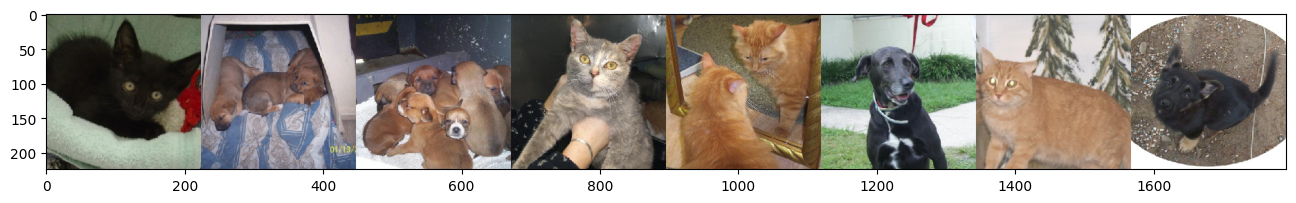

In [38]:
imgs = [image.load_img(data[i]['path'], target_size=(224, 224), keep_aspect_ratio=True) for i in range(8)]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Treinando uma rede do zero

Antes de fazer o `Transfer Learning` será feito o treinamento de uma rede sem qualquer peso de conhecimentos prévios. O objetivo é ter um resultado prévio para os mesmos dados e comparar com o resultado da rede gerada pelo `Transfer Learning`.  

A rede contém 4 camadas convolucionais alternadas e max-pooling, seguida por um [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) após cada outro par conv/pooling. Após a última camada pooling, é anexada uma camada totalmente conectada de 256 neurônios, outra camada dropout, e finalmente uma camada de classificação softmax para as categorias.

A função `loss` será, comom de costume, `categorical cross-entropy loss`, e o algoritmos de treinamento será o [AdaDelta](https://arxiv.org/abs/1212.5701).

A rede pode ser alterada para obtenção de melhor performance, entretanto para o propósito deste projeto o objetivo é obter conhecimento para um ponto de partida para comparação.

Após a compilação da rede executaremos `model.summary()` para pmostrar um snapshot de suas camadas.

In [39]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Foi criada uma rede de tamanho médio com ~1.2 milhões de pesos e biases (os parâmetros). A maioria deles leva a uma camada totalmente conectada pre-softmax "dense_5".

Agora é possível seguir para o treinamento do modelo para 100 épocas com um tamanho de lote de 128.

O histórico do treinamento será salvo para visualização do valor de `loss` ao longo do tempo.

In [40]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4933 - loss: 75.7682 - val_accuracy: 0.5033 - val_loss: 1.4294
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.4979 - loss: 1.2034 - val_accuracy: 0.5400 - val_loss: 0.6951
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.5076 - loss: 0.7119 - val_accuracy: 0.4867 - val_loss: 0.7002
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.5080 - loss: 0.7088 - val_accuracy: 0.5300 - val_loss: 0.6965
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5122 - loss: 0.6999 - val_accuracy: 0.5300 - val_loss: 0.6948
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.5171 - loss: 0.6978 - val_accuracy: 0.5733 - val_loss: 0.6913
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.5363 - loss: 0.6882 - val_accuracy: 0.5900 - val_loss: 0.6881
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.5630 - loss: 0.6915 - val_accuracy: 0.

Agora é apresentado os gráfico de `loss`e  `validation accuracy` ao longo do tempo.

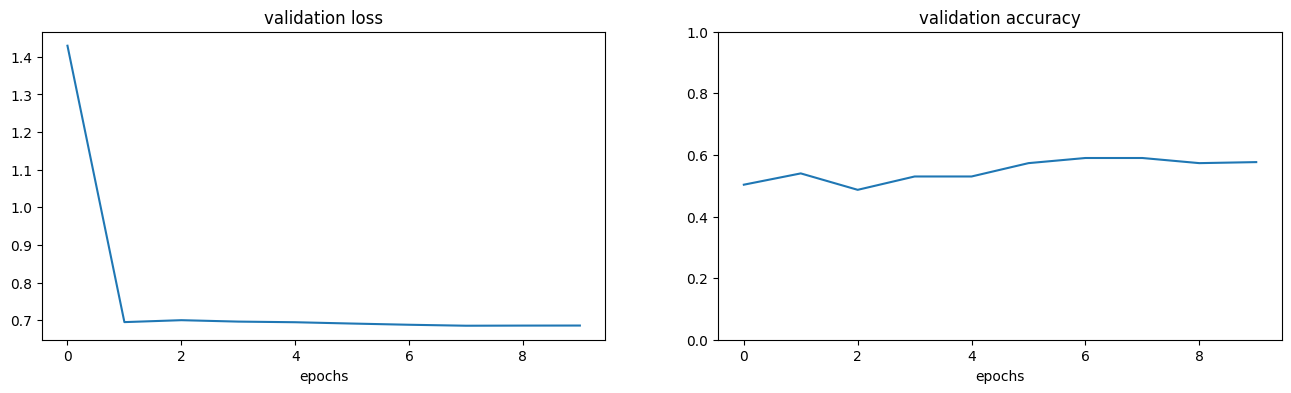

In [42]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

A `validation accuracy` permanece entre 40% e 60%.

O próxima etapa é realizar uma avaliação final executando o modelo sobre o conjunto de validação, alcançando os resultados abaixo:

In [43]:
loss, accuracy = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6860105991363525
Test accuracy: 0.5766666531562805


Finalmente, pode ser observado que obteve-se uma (top-1) exatidão entorno de 57%. quer não é tão ruim para 1400 imagens, considerando que utilizando uma estratégia ingênua de palpites aleatórios, seria obtido uma exatidão entorno de somento 1%.

## Transfer learning a partir de uma rede existente

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the `summary()` method.

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467904/553467096 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_po

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are not just 97, but 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 97 neurons in the case of the 101_ObjectCategories dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset.

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

In the case of CalTech-101, we will just do feature extraction, fearing that fine-tuning too much with this dataset may overfit. But maybe we are wrong? A good exercise would be to try out both, and compare the results.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 97-neuron softmax. Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have 397,000 trainable parameters, which is actually only a quarter of the number of parameters needed to train the first model.

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 66s 15ms/step - loss: 4.0574 - acc: 0.1631 - val_loss: 3.1996 - val_acc: 0.3040
Epoch 2/10
4346/4346 [==============================] - 46s 11ms/step - loss: 2.5812 - acc: 0.4441 - val_loss: 2.3154 - val_acc: 0.5070
Epoch 3/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.9747 - acc: 0.5630 - val_loss: 1.9155 - val_acc: 0.5585
Epoch 4/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.6366 - acc: 0.6305 - val_loss: 1.7621 - val_acc: 0.5768
Epoch 5/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.4263 - acc: 0.6795 - val_loss: 1.5046 - val_acc: 0.6681
Epoch 6/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.2610 - acc: 0.7098 - val_loss: 1.4539 - val_acc: 0.6477
Epoch 7/10
4346/4346 [==============================] - 46s 11ms/step - loss: 1.1283 - acc: 0.7407 - val_loss: 1.3778 - val_acc: 0.6778
E

Our validation accuracy hovers close to 80% towards the end, which is more than 30% improvement on the original network trained from scratch (meaning that we make the wrong prediction on 20% of samples, rather than 50%).

It's worth noting also that this network actually trains _slightly faster_ than the original network, despite having more than 100 times as many parameters! This is because freezing the weights negates the need to backpropagate through all those layers, saving us on runtime.

Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model in green.

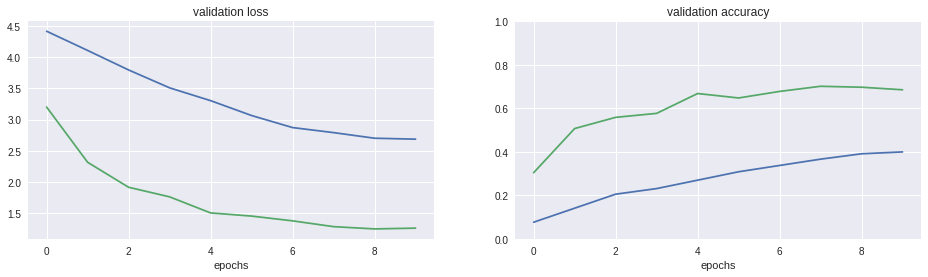

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.plot(history2.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Notice that whereas the original model began overfitting around epoch 16, the new model continued to slowly decrease its loss over time, and likely would have improved its accuracy slightly with more iterations. The new model made it to roughly 80% top-1 accuracy (in the validation set) and continued to improve slowly through 100 epochs.

It's possibly we could have improved the original model with better regularization or more dropout, but we surely would not have made up the >30% improvement in accuracy.

Again, we do a final validation on the test set.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.1540323304004423
Test accuracy: 0.7156652360515021


To predict a new image, simply run the following code to get the probabilities for each class.

In [ ]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])


0.6425913


### Improving the results

78.2% top-1 accuracy on 97 classes, roughly evenly distributed, is a pretty good achievement. It is not quite as impressive as the original VGG16 which achieved 73% top-1 accuracy on 1000 classes. Nevertheless, it is much better than what we were able to achieve with our original network, and there is room for improvement. Some techniques which possibly could have improved our performance.

- Using data augementation: augmentation refers to using various modifications of the original training data, in the form of distortions, rotations, rescalings, lighting changes, etc to increase the size of the training set and create more tolerance for such distortions.
- Using a different optimizer, adding more regularization/dropout, and other hyperparameters.
- Training for longer (of course)

A more advanced example of transfer learning in Keras, involving augmentation for a small 2-class dataset, can be found in the [Keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).